# **TP MACHINE LEARNING 1 . 2025-2026 . KNN ET ARBRES DE DECISION**

Version du 14/11/2025

In [1]:
# Chargement des biblothèques diverses utilisées pendant le TP.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

**Première partie** : reconnaissance de chiffres manuscrits.

Le premier jeu de données est : Optical Recognition of Handwritten Digits. NIST from M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson, NIST Form-Based Handprint Recognition System, NISTIR 5469, 1994.

In [2]:
# Chargement des données.
chiffres = load_digits()
X = chiffres.images
Y = chiffres.target

On commence par quelques statistiques descriptives et par visualiser les données.

In [3]:
# Taille n de l'échantillon et dimension d des données.
print("Taille de l'échantillon :", len(X))
print("Dimension du vecteur de variables (features) :", X.shape[1] * X.shape[2])

Taille de l'échantillon : 1797
Dimension du vecteur de variables (features) : 64


In [5]:
# 10 classes (les chiffres de 0 à 9) dont on calcule l'effectif dans l'échantillon.
unique, counts = np.unique(Y, return_counts=True)
print("Classe | Effectif")
print("------------------")
for u, c in zip(unique, counts):
    print(f"{u:<6} | {c}")

Classe | Effectif
------------------
0      | 178
1      | 182
2      | 177
3      | 183
4      | 181
5      | 182
6      | 181
7      | 179
8      | 174
9      | 180


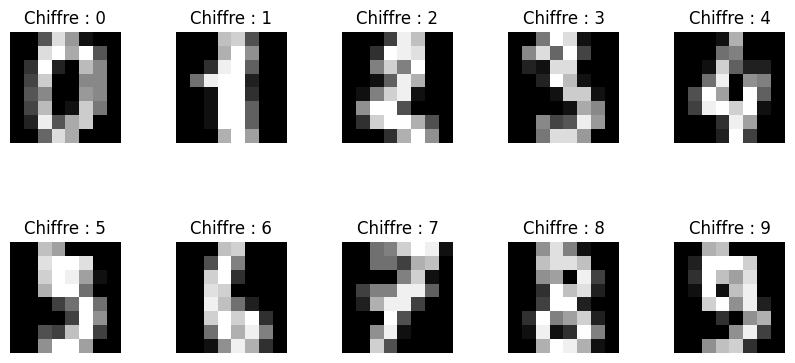

In [6]:
# Affichage des images correspondant aux premiers 10 éléments du jeu de données.
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(X[i], cmap='gray')
    axes[i].set_title("Chiffre : %s" % Y[i])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

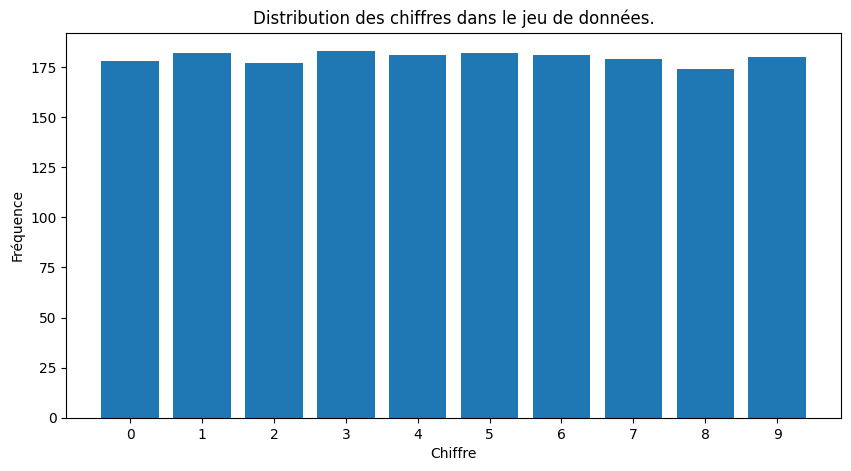

In [7]:
# Distribution des chiffres dans l'échantillon
plt.figure(figsize=(10, 5))
plt.bar(unique, counts)
plt.xticks(unique)
plt.xlabel("Chiffre")
plt.ylabel("Fréquence")
plt.title("Distribution des chiffres dans le jeu de données.")
plt.show()

A quoi ressemnblent les chiffres *moyens* ?

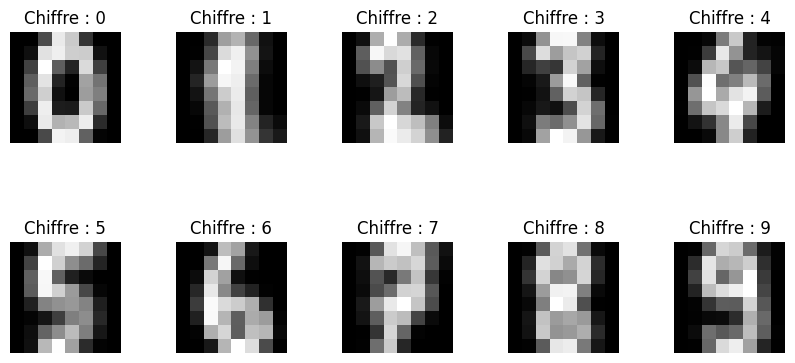

In [8]:
# On calcule la moyenne de l'image de chaque chiffre sur l'ensemble du jeu de données...
avg_images = np.array([np.mean(X[Y == i], axis=0) for i in range(10)])
# ... et on l'affiche
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(avg_images[i], cmap='gray')
    axes[i].set_title("Chiffre : %s" % i)
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)



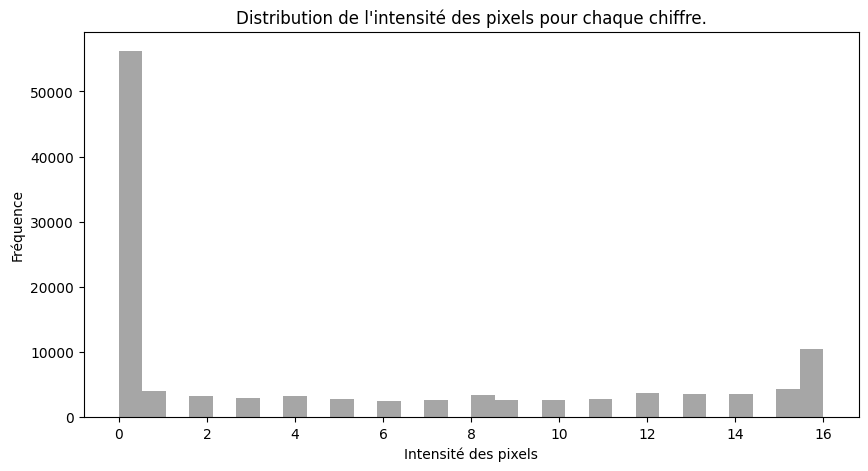

In [9]:
# Modification de la taille des données pour les transformer en vecteurs de 64 coordonnées.
X2d = X.reshape(X.shape[0], -1)
# Histogramme de l'intensité des pixels
plt.figure(figsize=(10, 5))
plt.hist(X2d.ravel(), bins=30, color='gray', alpha=0.7)
plt.title("Distribution de l'intensité des pixels pour chaque chiffre.")
plt.xlabel("Intensité des pixels")
plt.ylabel("Fréquence")
plt.show()

In [10]:
print(X2d)
X2d.shape

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


(1797, 64)

3°. Utilisation de t-SNE pour visualiser le nuage de points en deux dimensions et pour distinguer au mieux les différentes classes malgré la faible dimension.

/tmp/ipython-input-997234020.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(Xtsne[:, 0], Xtsne[:, 1], c=Y, edgecolor='none', alpha=0.7, cmap=plt.cm.get_cmap('nipy_spectral', 10))


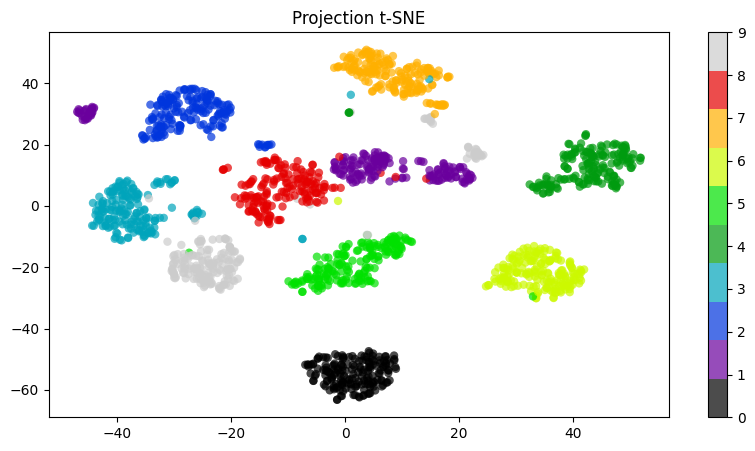

In [11]:
# Visualisation en utilisant t-SNE
tsne = TSNE(n_components=2, random_state=0)
Xtsne = tsne.fit_transform(X2d)
plt.figure(figsize=(10, 5))
plt.scatter(Xtsne[:, 0], Xtsne[:, 1], c=Y, edgecolor='none', alpha=0.7, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title("Projection t-SNE")
plt.show()

4°. Utilisation de l'algorithme des $k$-ppv pour classer les chiffres. On sépare les données en deux : ensemble d'entrainement (20% des données) et ensemble de test. On classifie via l'algorithme $k$-NN puis on évalue les performances. Les fonctions les plus importantes ici sont KNeighborsClassifier et GridSearchCV.

In [13]:
# Chargement des données.
digits = load_digits()
# On transforme en vecteurs de 64 coordonnées les images.
X = digits.images.reshape((len(digits.images), -1))
Y = digits.target
# Découpage des données (20% pour le test, 80% pour l'entrainement).
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)
# On propose les plages de valeurs pour les hyperparamètres :
parametres = {'n_neighbors': [1,2,3,4,5,6,7,8, 9,11],'weights': ['uniform', 'distance'],'p': [1, 2]}
# Initialisation du modèle kNN.
knn = KNeighborsClassifier()
# Initialisation de la grille qui va tester toutes les valeurs des hyperparamètres.
grid_search = GridSearchCV(knn, parametres, cv=5, scoring='accuracy')
# knn est testé avec chaque valeur possible des hyperparamètres.
grid_search.fit(X_train, Y_train)
# Affichage des meilleurs paramètres et des scores
print(grid_search.best_params_)
print(grid_search.best_score_)
# Entrainement du modele avec les hyperprams ayant donné les meilleurs scores.
knn = KNeighborsClassifier(**grid_search.best_params_)
knn.fit(X_train,Y_train)
Y_pred = knn.predict(X_test)
# Performances.
print(classification_report(Y_test, Y_pred))

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.9902463221060781
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      1.00      0.96        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       0.97      0.91      0.94        35
           9       1.00      0.94      0.97        36

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



5°. Qualité de la prédiction mesurée par la matrice de confusion.

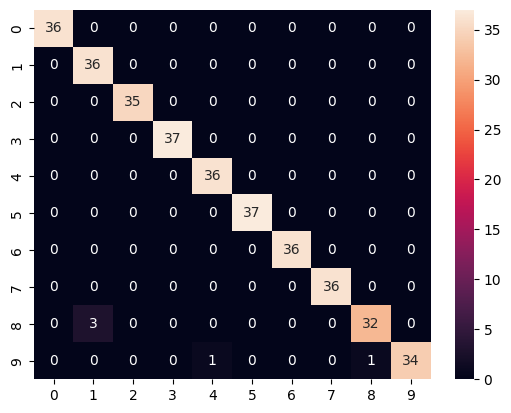

In [14]:
# Matrice de confusion.
Mconf = confusion_matrix(Y_test, Y_pred)
sns.heatmap(Mconf, annot=True, fmt='d')
plt.show()

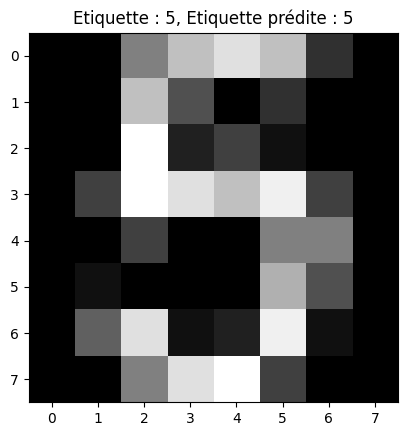

In [15]:
# Test sur une image, prédiction et visualisation.
test_image_index = 0
test_image = X_test[test_image_index]
test_image_label = Y_test[test_image_index]
test_image_pred = knn.predict(test_image.reshape(1, -1))

plt.imshow(test_image.reshape(8, 8), cmap='gray')
plt.title(f"Etiquette : {test_image_label}, Etiquette prédite : {test_image_pred[0]}")
plt.show()

6°. Construction d'un arbre de décision pour classer les chiffres manuscrits.

Dans la bibliothèque sklearn.tree de scikit-learn, on trouve tout ce qui concerne les arbres de décision, en particulier :

- DecisionTreeClassifier
- DecisionTreeRegressor
- plot_tree

Pour DecisionTreeClassifier :

- Méthodes : fit, predict, predict_proba, score, get_depth, get_n_leaves, get_params, set_params.
- Variables : classes_, tree_, etc.
- Principaux hyperparamètres: criterion (gini, entropy), max_depth, min_samples_split, min_samples_leaf, max_features, ccp_alpha, etc.

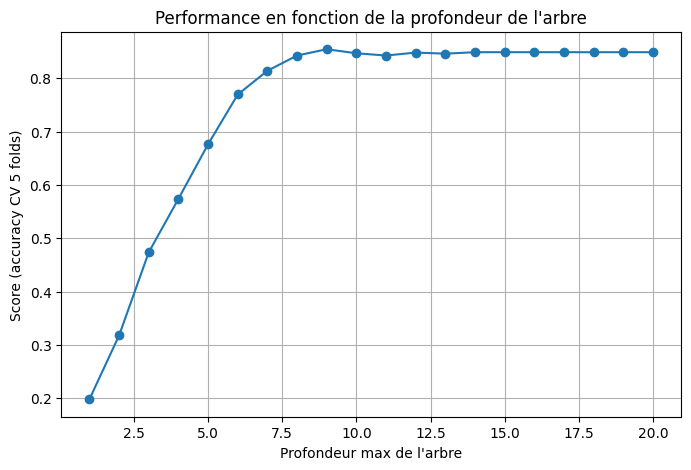

In [23]:
from sklearn import tree
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

prof = range(1, 21)
scoresmoy = []
for d in prof:
    arbre = tree.DecisionTreeClassifier(max_depth=d, random_state=0)
    scores = cross_val_score(arbre, X_train, Y_train, cv=5, scoring="accuracy")
    scoresmoy.append(scores.mean())
plt.figure(figsize=(8,5))
plt.plot(prof, scoresmoy, marker='o')
plt.xlabel("Profondeur max de l'arbre")
plt.ylabel("Score")
plt.title("Perf. en fonction de la profondeur de l'arbre")
plt.grid()
plt.show()


Exécution et performances de l'arbre de décision.

In [24]:
arbre = tree.DecisionTreeClassifier(max_depth = 9)
Y_pred = cross_val_predict(arbre, X_train, Y_train, cv=5)
arbre.fit(X_train, Y_train)
print("Score train :", arbre.score(X_train, Y_train))

Score train : 0.9679888656924147


Matrice de confusion.....

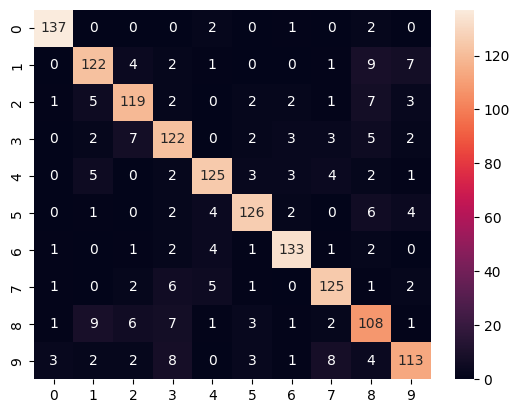

In [25]:
from sklearn.metrics import accuracy_score
Mconf2 = confusion_matrix(Y_train, Y_pred)
ax = sns.heatmap(Mconf2,annot=True,fmt='d')

... et courbe ROC. Ici, elle n'est pas très informative. On a 10 classes, il faudrait faire 10 courbes ROC ou les superposer. Par ailleurs, les perforances sont très bonnes. La matrice de confusion et le tableau des scores est suffisamment informatif.

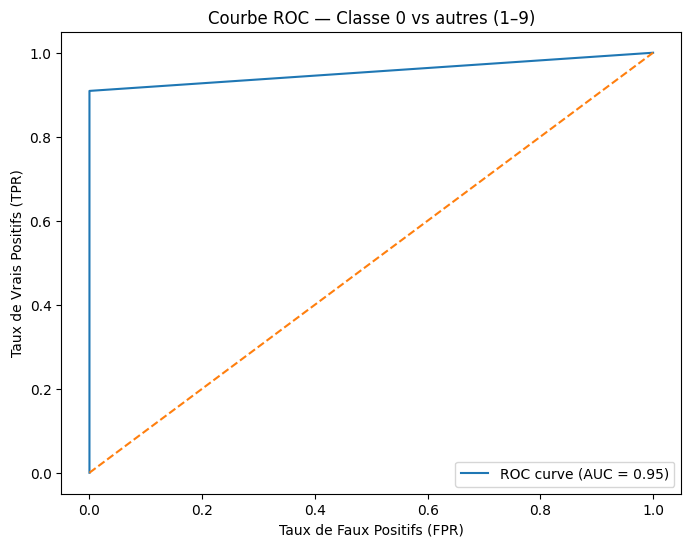

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer

digits = load_digits()
X = digits.data
Y = digits.target.astype(int)

# Binarisation : 0 = classe positive, 1–9 = négatives
lb = LabelBinarizer()
Y_bin = (Y == 0).astype(int)   # 1 si chiffre 0, sinon 0
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_bin, test_size=0.2, random_state=42)
arbre = tree.DecisionTreeClassifier(max_depth=10)
arbre.fit(X_train, Y_train)
Y_scores = arbre.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_scores)
auc_score = roc_auc_score(Y_test, Y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC — Classe 0 vs autres (1–9)')
plt.legend(loc="lower right")
plt.show()

7°. Affichage de l'arbre.

In [ ]:
from sklearn import tree
digits = load_digits()
X = digits.data
Y = digits.target.astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)
arbre = tree.DecisionTreeClassifier(max_depth = 2)
Y_pred = cross_val_predict(arbre, X_train, Y_train, cv=5)
arbre.fit(X_train, Y_train)
plt.figure(figsize=(15, 10))
tree.plot_tree(arbre,filled=True,feature_names=None,class_names=[str(i) for i in range(10)])

In [ ]:


from sklearn import tree
digits = load_digits()
X = digits.data
Y = digits.target.astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
arbre = tree.DecisionTreeClassifier(max_depth=5)
Y_pred = cross_val_predict(arbre, X_train, Y_train, cv=5)
arbre.fit(X_train, Y_train)

plt.figure(figsize=(26, 16))
texts = tree.plot_tree(arbre,filled=True,class_names=[str(i) for i in range(10)],feature_names=None,fontsize=12)
for t in texts:
    s = t.get_text()
    if "value =" in s:
        lines = s.split("\n")
        new_lines = [L for L in lines if not L.strip().startswith("value")]
        t.set_text("\n".join(new_lines))
plt.tight_layout()
plt.show()

In [51]:
from sklearn.tree import export_graphviz
import graphviz
dot = export_graphviz(
    arbre,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=[str(i) for i in range(10)],
    feature_names=[f"x[{i}]" for i in range(X_train.shape[1])],
    max_depth=4
)
graph = graphviz.Source(dot)
graph.render("arbre_etage", format="png", cleanup=True)

'arbre_etage.png'

8°. Jeu de données MNIST composé de $60 000$ images et utilisé par Yann le Cun

In [52]:
!pip install python-mnist

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

Précision de l'arbre de décision : 87.26%

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1343
           1       0.94      0.95      0.95      1600
           2       0.87      0.84      0.85      1380
           3       0.84      0.84      0.84      1433
           4       0.85      0.88      0.86      1295
           5       0.83      0.82      0.82      1273
           6       0.89      0.90      0.90      1396
           7       0.91      0.91      0.91      1503
           8       0.83      0.80      0.82      1357
           9       0.84      0.84      0.84      1420

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



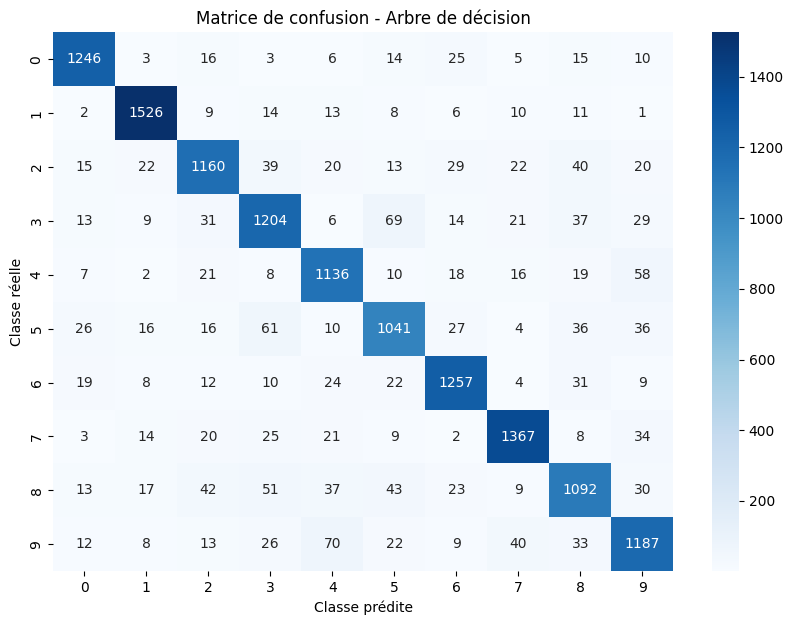

In [57]:
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
# Chargeons les données MNIST
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision de l'arbre de décision : {accuracy * 100:.2f}%")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Matrice de confusion - Arbre de décision")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

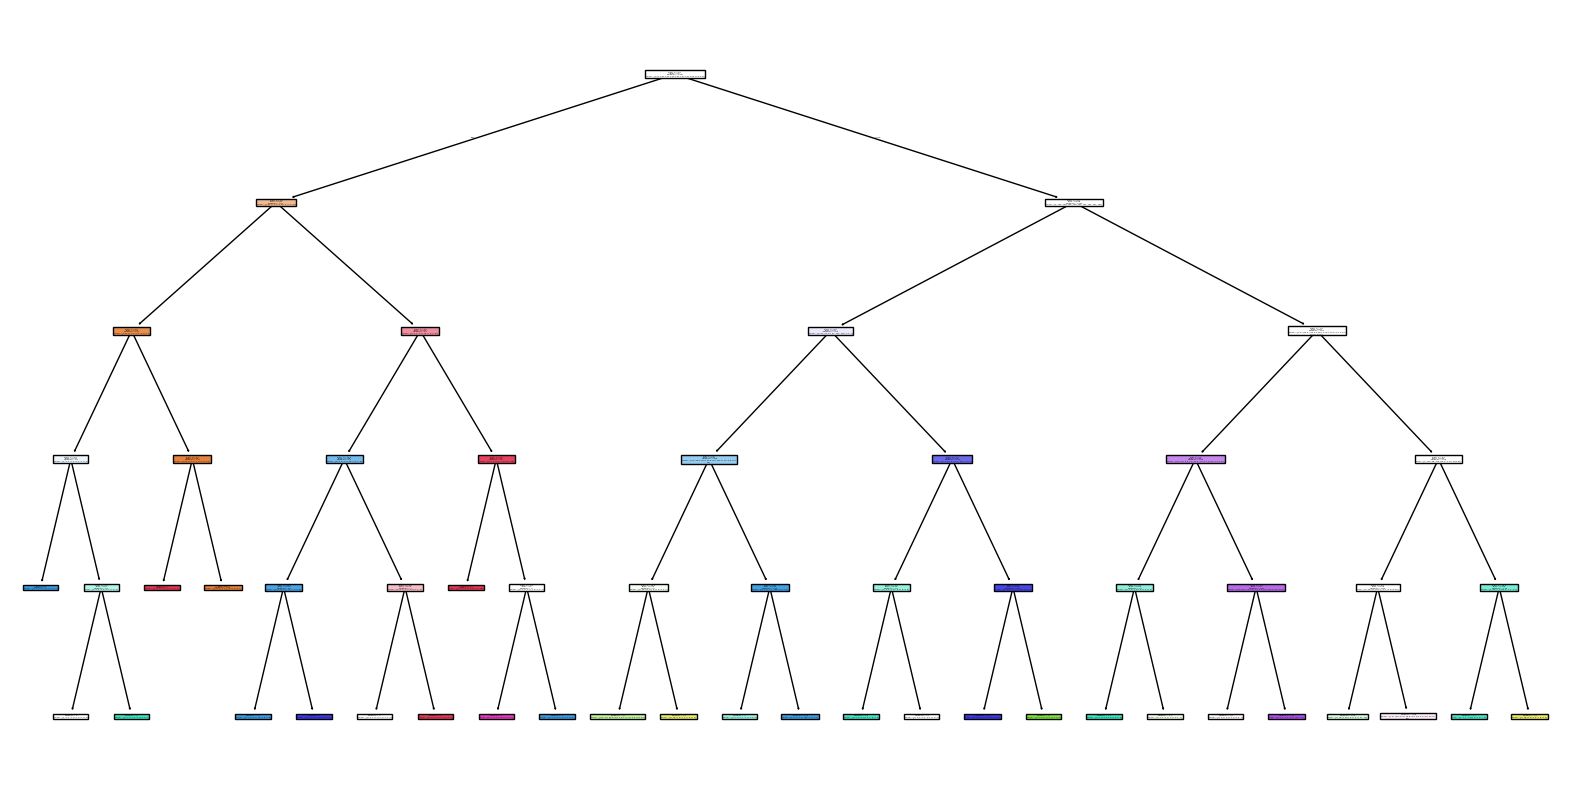

In [58]:
from sklearn import tree
plt.figure(figsize=(20,10))
tree.plot_tree(arbre, filled=True)
plt.show()

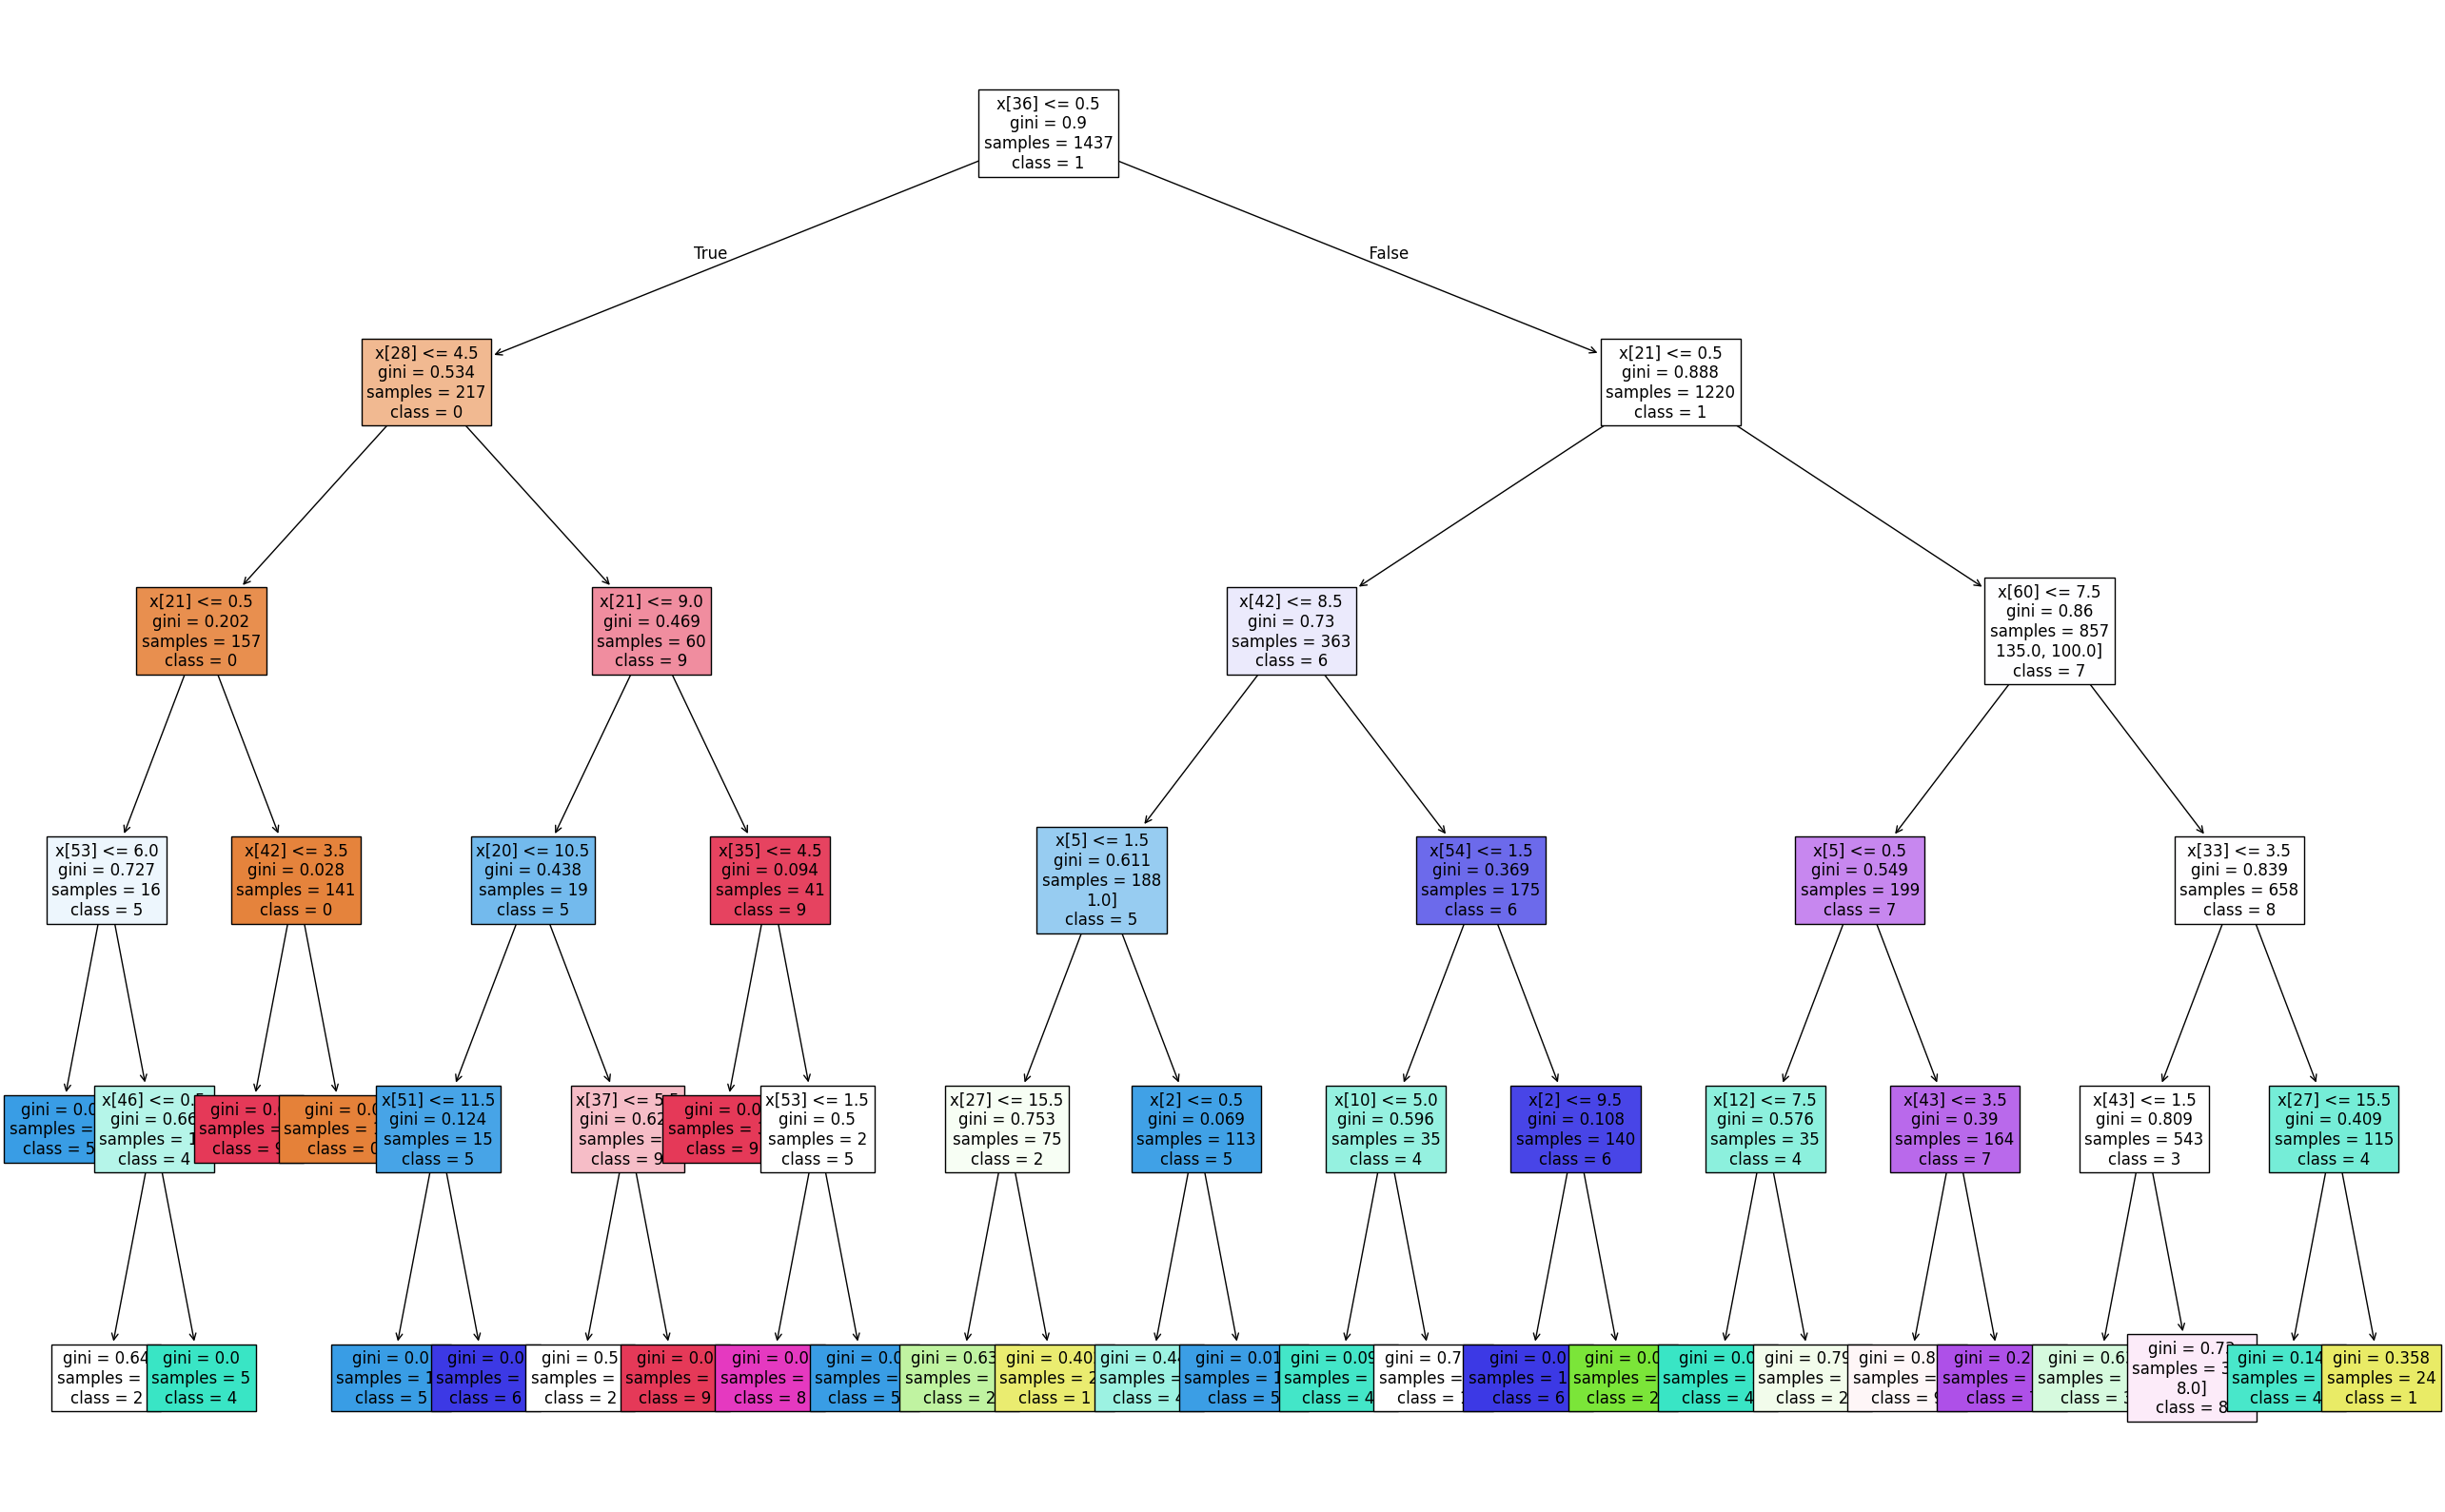

In [60]:
plt.figure(figsize=(26, 16))
texts = tree.plot_tree(arbre,filled=True,class_names=[str(i) for i in range(10)],feature_names=None,fontsize=12)
for t in texts:
    s = t.get_text()
    if "value =" in s:
        lines = s.split("\n")
        new_lines = [L for L in lines if not L.strip().startswith("value")]
        t.set_text("\n".join(new_lines))
plt.tight_layout()
plt.show()